## Define Imports

In [6]:
import math # Mathematical functions 
import numpy as np # Fundamental package for scientific computing with Python
import pandas as pd # Additional functions for analysing and manipulating data
from datetime import date, timedelta, datetime # Date Functions
from pandas.plotting import register_matplotlib_converters # This function adds plotting functions for calender dates
import matplotlib.pyplot as plt # Important package for visualization - we use this to plot the market data
import matplotlib.dates as mdates # Formatting dates
import tensorflow as tf
from sklearn.metrics import mean_absolute_error, mean_squared_error # Packages for measuring model performance / errors
from keras import Sequential # Deep learning library, used for neural networks
from keras.layers import LSTM, Dense, Dropout,SimpleRNN,GRU # Deep learning classes for recurrent and regular densely-connected layers
from keras.callbacks import EarlyStopping # EarlyStopping during model training
# from keras.models import Sequential
# from keras.layers import Dense, SimpleRNN , Dropout, LSTM, GRU
from sklearn.preprocessing import RobustScaler, MinMaxScaler # This Scaler removes the median and scales the data according to the quantile range to normalize the price data 
import seaborn as sns # Visualization
sns.set_style('white', { 'axes.spines.right': False, 'axes.spines.top': False})
%matplotlib inline
# import matplotlib.pyplot as plt
# import numpy as np
# import pandas as pd
#mounting drive
from google.colab import drive
drive.mount('/content/drive')
data_dir = '/content/drive/MyDrive/Deep_Learning/MSFT.csv'
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
from sklearn.preprocessing import MinMaxScaler

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# import yfinance
# msft = yf.download(MSFT, start=start_date, end=end_date)
# hist = msft.history(period='max')
# hist

In [7]:
MSFT = pd.read_csv(data_dir)
# MSFT = MSFT.iloc[7000:,:]
MSFT = MSFT
MSFT = MSFT.set_index('Date')
display(MSFT)
MSFT.describe()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1986-03-13,0.088542,0.101562,0.088542,0.097222,0.062378,1031788800
1986-03-14,0.097222,0.102431,0.097222,0.100694,0.064606,308160000
1986-03-17,0.100694,0.103299,0.100694,0.102431,0.065720,133171200
1986-03-18,0.102431,0.103299,0.098958,0.099826,0.064049,67766400
1986-03-19,0.099826,0.100694,0.097222,0.098090,0.062935,47894400
...,...,...,...,...,...,...
2020-03-26,148.399994,156.660004,148.369995,156.110001,156.110001,64568100
2020-03-27,151.750000,154.889999,149.199997,149.699997,149.699997,57042300
2020-03-30,152.440002,160.600006,150.009995,160.229996,160.229996,63420300


,Open,High,Low,Close,Adj Close,Volume
count,8584.000000,8584.000000,8584.000000,8584.000000,8584.000000,8.584000e+03
mean,29.156231,29.471181,28.836751,29.161905,24.323514,6.039485e+07
std,30.689046,30.981768,30.373424,30.694762,30.369640,3.883519e+07
min,0.088542,0.092014,0.088542,0.090278,0.057923,2.304000e+06
25%,3.492188,3.523438,3.448242,3.492188,2.240606,3.654795e+07
50%,26.250000,26.570000,25.959999,26.250000,18.472112,5.364225e+07
75%,34.549999,34.990002,34.093750,34.542500,25.608809,7.408665e+07
max,190.649994,190.699997,186.470001,188.699997,188.185989,1.031789e+09


In [8]:
import plotly.graph_objects as go
import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(go.Scatter(x=MSFT.index,y=MSFT['Adj Close'],name='Closing Price'),secondary_y=False)
# fig.add_trace(go.Bar(x=MSFT['Date'],y=MSFT['Volume'],name='Volume'),secondary_y=True)
fig.show()

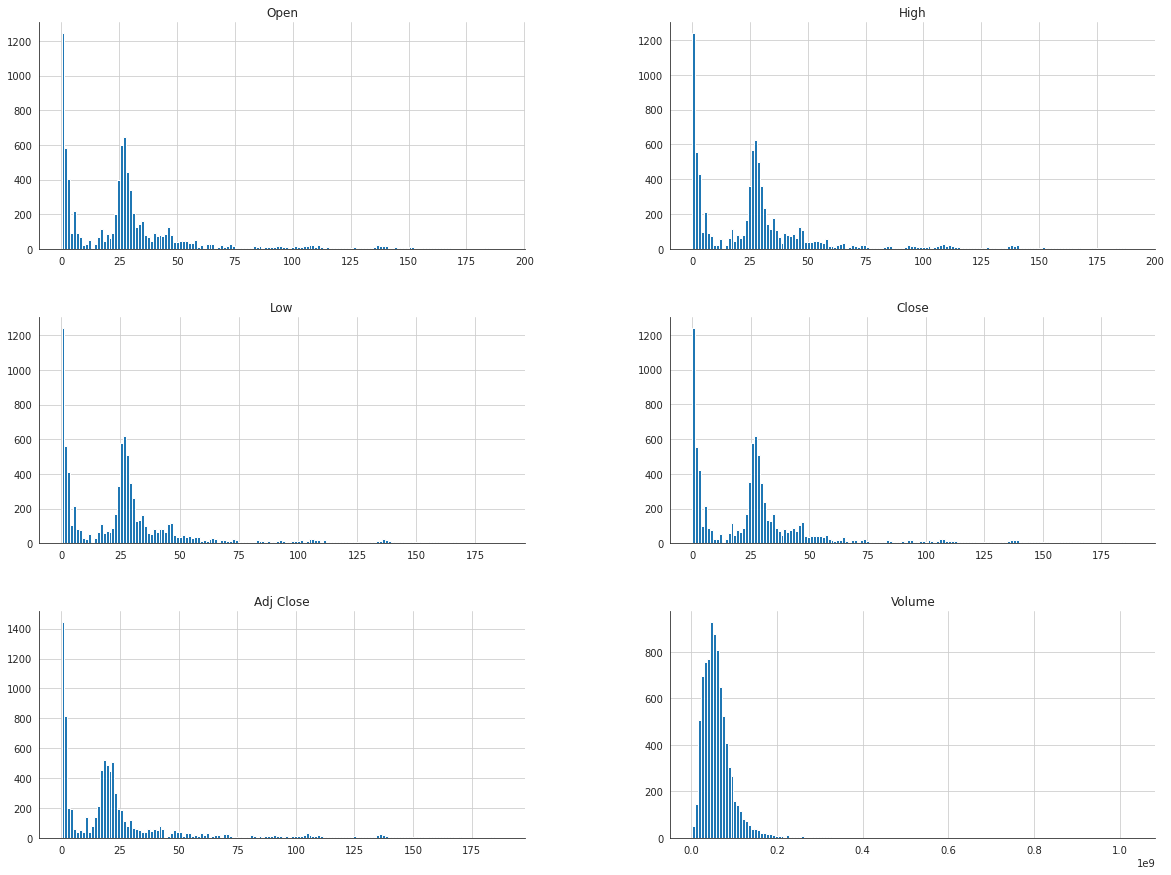

In [9]:
# Plot line charts
df_plot = MSFT.copy()
df_plot.hist(bins=150,figsize=(20,15))
plt.show()

In [10]:
class Basenet():

    def __init__(self,index_Close,sequence_length):
        self.train_set = None
        self.val_set = None
        self.test_set = None
        self.index_Close = index_Close
        self.sequence_length = sequence_length
        self.optimizer = None


    def pre_processdata(self,filtered_df):

        scaler = MinMaxScaler()
        data_scaled = scaler.fit_transform(filtered_df)
        df_Close = pd.DataFrame(filtered_df['Close'])

        scaler_pred = MinMaxScaler()
        np_Close_scaled = scaler_pred.fit_transform(df_Close)
        
        return data_scaled,scaler_pred
        
    def partition_dataset(self,sequence_length, data):
        x, y = [], []
        data_len = data.shape[0]
        for i in range(sequence_length, data_len):
            x.append(data[i-sequence_length:i,:]) #contains sequence_length values 0-sequence_length * columsn
            y.append(data[i, self.index_Close]) #contains the prediction values for validation,  for single-step prediction
        
        # Convert the x and y to numpy arrays
        x = np.array(x)
        y = np.array(y)
        return x, y

    def split_data(self,stock,splitsize):
        # data_raw = stock.to_numpy() # convert to numpy array
        data = stock.copy()
        #calc test size
        data = np.array(data)
        test_size = int(np.round(len(data)*splitsize))
        bg_train_size = len(data) - test_size
        val_size = int(np.round(bg_train_size*(splitsize/2)))
        train_size = bg_train_size - val_size
        print(f"Train :{train_size}, Val :{val_size}, test :{test_size}")
        self.train_set = data[:train_size,:]
        self.val_set = data[train_size:bg_train_size,:]
        self.test_set = data[bg_train_size:,:]

#         x_train = data[:train_size,:-1]
#         y_train = data[:train_size,-1]
        print("Training Size :",len(self.train_set))
        print("Validation Size :",len(self.val_set))
#         x_test = data[train_size:,:-1]
#         y_test = data[train_size:,-1]
        print("Testing Size :",len(self.test_set))

        sequence_length = self.sequence_length
        x_train,y_train = self.partition_dataset(sequence_length,self.train_set)
        x_val,y_val = self.partition_dataset(sequence_length,self.val_set)
        x_test,y_test = self.partition_dataset(sequence_length,self.val_set)
        # print(f"x_val{x_val.shape},y_val{y_val.shape}")
        print(f"X_Training Shape : {x_train.shape}")
        print(f"y_Training Shape : {y_train.shape}")
        print(f"X_Validation : {x_val.shape}")
        print(f"Y_Validation : {y_val.shape}")
        print(f"X_Testing : {x_test.shape}")
        print(f"Y_Testing : {y_test.shape}")

        return x_train,y_train,x_val,y_val,x_test,y_test


    def train(self,model,epochs,x_train,y_train,x_val,y_val,scaler_pred,batch_size = 16):

        # Training the model
        early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)

        history = model.fit(x_train, y_train, 
                            batch_size=batch_size, 
                            epochs=epochs,
                            validation_data=(x_val, y_val)
                          )
                            
                            # callbacks=[early_stop])
        # Get the predicted values
        y_pred_scaled = model.predict(x_val)

        # Unscale the predicted values
        y_pred = scaler_pred.inverse_transform(y_pred_scaled)
        y_val_unscaled = scaler_pred.inverse_transform(y_val.reshape(-1, 1))

        return history,y_pred_scaled,y_pred,y_val_unscaled

    def plot_Loss (self, history):
        fig, ax = plt.subplots(figsize=(16, 5), sharex=True)
        sns.lineplot(data=history.history["loss"])
        sns.lineplot(data=history.history["val_loss"])
        plt.title("Model loss")
        plt.ylabel("Loss")
        plt.xlabel("Epoch")
        ax.xaxis.set_major_locator(plt.MaxNLocator(50))
        plt.legend(["Train", "Val"], loc="upper right")
        plt.grid()
        plt.show()
    

## Data pre-processing

>  we drop Columns Date since this does not give valuable information regarding stock price instead is just a measure of time passsing

> we drop Adjusted close since it is calculated after market closing post divident claculation and is not a continoues flow .



In [11]:
# # Indexing Batches
# train_df = df.sort_values(by=['Date']).copy()
filtered_df = MSFT.copy()
# Removing Adjusted Close Column
filtered_df = filtered_df.drop([ 'Adj Close'], axis=1)
filtered_df['Prediction'] = filtered_df['Close']
# Print the tail of the dataframe
display(filtered_df.tail())

#Using Min-Max scaling to make data more uniform

# Get the number of rows in the data
# nrows = data_filtered.shape[0]

# # Convert the data to numpy values
# np_data_unscaled = np.array(data_filtered)
# np_data = np.reshape(np_data_unscaled, (nrows, -1))
# print(np_data.shape)

# Transform the data by scaling each feature to a range between 0 and 1
# scaler = MinMaxScaler()
# data_scaled = scaler.fit_transform(filtered_df)
# # Creating a separate scaler that works on a single column for scaling predictions

# scaler_pred = MinMaxScaler()
# df_Close = pd.DataFrame(filtered_df['Close'])
# np_Close_scaled = scaler_pred.fit_transform(df_Close)
# df_Close.shape

,Open,High,Low,Close,Volume,Prediction
Date,,,,,,
2020-03-26,148.399994,156.660004,148.369995,156.110001,64568100,156.110001
2020-03-27,151.750000,154.889999,149.199997,149.699997,57042300,149.699997
2020-03-30,152.440002,160.600006,150.009995,160.229996,63420300,160.229996
2020-03-31,159.399994,164.779999,156.559998,157.710007,77927200,157.710007
2020-04-01,153.000000,157.750000,150.820007,152.110001,57858300,152.110001


# LSTM

In [12]:

class LSTM_cls(Basenet):

  def __init__(self,index_Close,sequence_length):
    super().__init__(index_Close,sequence_length)
    self.x_train = None
    self.y_pred =None

  def LSTM_model(self,x_train,optimizer = 'adam',lr=0.001):
    sequence_length = self.sequence_length
    if optimizer == 'adam':
      self.optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    elif optimizer == 'sgd': 
      self.optimizer = tf.keras.optimizers.SGD(learning_rate=lr, momentum=0.0)

    model = Sequential()
    # Model with n_neurons = inputshape Timestamps, each with self.train_set.shape[2] variables
    n_neurons = x_train.shape[1] * x_train.shape[2]
    # print(n_neurons, self.train_set.shape[1], self.train_set.shape[2])
    model.add(
        LSTM(
            n_neurons, return_sequences=True, 
             input_shape=(x_train.shape[1],x_train.shape[2]))
        ) 
    model.add(
        LSTM(n_neurons, return_sequences=False)
        )
    model.add(Dense(5))
    model.add(Dense(1))

    # Compile the model
    model.compile(optimizer=self.optimizer, loss='mse')
    return model


In [13]:
optimizer = 'adam'
lr=0.001
batch_size = 16
epochs = 20
index_Close = 3
sequence_length = 20

lstm = LSTM_cls(index_Close,sequence_length)
data_scaled,scaler_pred = lstm.pre_processdata(filtered_df)
x_train,y_train,x_val,y_val,x_test,y_test = lstm.split_data(data_scaled,.2)

lstm_model = lstm.LSTM_model(x_train,optimizer,lr)
history,y_pred_scaled,y_pred,y_val_unscaled = lstm.train(lstm_model,epochs,x_train,y_train,x_val,y_val,scaler_pred,batch_size)
# Plot training & validation loss values
lstm.plot_Loss (history)
print("------------------------------------------------------")
# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_val_unscaled, y_pred)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_val_unscaled, y_pred)/ y_val_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_val_unscaled, y_pred)/ y_val_unscaled)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')

Train :6180, Val :687, test :1717
bg_train : 6867
Training Size : 6180
Validation Size : 687
Testing Size : 1717
X_Training Shape : (6160, 20, 6)
y_Training Shape : (6160,)
X_Validation : (667, 20, 6)
Y_Validation : (667,)
X_Testing : (667, 20, 6)
Y_Testing : (667,)
Epoch 1/20
385/385 [==============================] - 21s 43ms/step - loss: 9.5629e-05 - val_loss: 3.4276e-05
Epoch 2/20
385/385 [==============================] - 18s 47ms/step - loss: 3.2269e-05 - val_loss: 1.0616e-05
Epoch 3/20
385/385 [==============================] - 18s 47ms/step - loss: 2.7536e-05 - val_loss: 6.8631e-05
Epoch 4/20
385/385 [==============================] - 15s 40ms/step - loss: 2.1341e-05 - val_loss: 1.2026e-05
Epoch 5/20
385/385 [==============================] - 14s 36ms/step - loss: 1.8967e-05 - val_loss: 1.3373e-05
Epoch 6/20
385/385 [==============================] - 19s 48ms/step - loss: 1.8207e-05 - val_loss: 1.0177e-05
Epoch 7/20
385/385 [==============================] - 17s 44ms/step - los

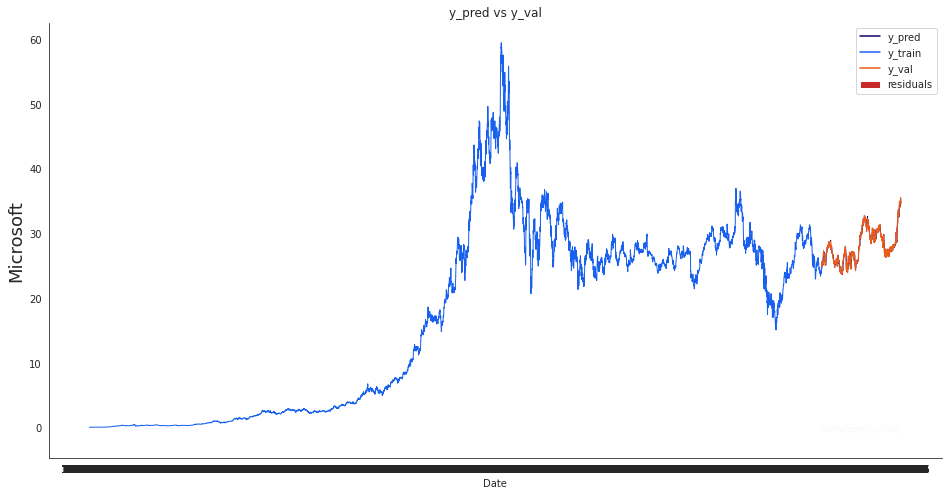

In [10]:
# The date from which on the date is displayed
display_start_date = "1986-01-01" 
train_data_len = len(lstm.train_set)
val_data_len = len(lstm.train_set) + len(lstm.val_set)
# Add the difference between the valid and predicted prices
train = pd.DataFrame(df_Close['Close'][lstm.sequence_length:train_data_len + 1]).rename(columns={'Close': 'y_train'})
valid = pd.DataFrame(df_Close['Close'][train_data_len+lstm.sequence_length:val_data_len]).rename(columns={'Close': 'y_val'})
valid.insert(1, "y_pred", y_pred, True)
valid.insert(1, "residuals", valid["y_pred"] - valid["y_val"], True)
df_union = pd.concat([train, valid])

# Zoom in to a closer timeframe
df_union_zoom = df_union[df_union.index > display_start_date]

# Create the lineplot
fig, ax1 = plt.subplots(figsize=(16, 8))
plt.title("y_pred vs y_val")
plt.ylabel("Microsoft", fontsize=18)
sns.set_palette(["#090364", "#1960EF", "#EF5919"])
sns.lineplot(data=df_union_zoom[['y_pred', 'y_train', 'y_val']], linewidth=1.0, dashes=False, ax=ax1)

# Create the bar plot with the differences
df_sub = ["#2BC97A" if x > 0 else "#C92B2B" for x in df_union_zoom["residuals"].dropna()]
ax1.bar(height=df_union_zoom['residuals'].dropna(), x=df_union_zoom['residuals'].dropna().index, width=3, label='residuals', color=df_sub)
plt.legend()
plt.show()

## Vanilla RNN

In [11]:

class V_RNN_cls(Basenet):

  def __init__(self,index_Close):
    super().__init__(index_Close)
    self.x_train = None
    self.y_pred =None
    

  # def train(self,model,epochs,batch_size = 16):
  #   sequence_length = self.sequence_length
  #   x_train,y_train = self.partition_dataset(sequence_length,self.train_set)
  #   x_val,y_val = self.partition_dataset(sequence_length,self.val_set)
  #   # print(f"x_val{x_val.shape},y_val{y_val.shape}")
  #   print(f"trainx : {x_train.shape}")
  #   print(f"valx : {x_val.shape}")
  #   print(f"y_train : {y_train.shape}")
  #   print(f"y_val : {y_val.shape}")

  #   # Training the model
  #   early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)
  #   history = model.fit(x_train, y_train, 
  #                       batch_size=batch_size, 
  #                       epochs=epochs,
  #                       validation_data=(x_val, y_val)
  #                     )
                        
  #                       # callbacks=[early_stop])
  #   # Get the predicted values
  #   y_pred_scaled = model.predict(x_val)

  #   # Unscale the predicted values
  #   y_pred = scaler_pred.inverse_transform(y_pred_scaled)
  #   y_val_unscaled = scaler_pred.inverse_transform(y_val.reshape(-1, 1))

  #   return history,y_pred_scaled,y_pred,y_val_unscaled

  def VRNN_model(self,sequence_length,optimizer = 'adam',lr=0.001):
    self.sequence_length =sequence_length
    x_train,y_train = self.partition_dataset(sequence_length,self.train_set)
    self.x_train = x_train
    if optimizer == 'adam':
      self.optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    elif optimizer == 'sgd': 
      self.optimizer = tf.keras.optimizers.SGD(learning_rate=lr, momentum=0.0)
    n_neurons = self.x_train.shape[1] * self.x_train.shape[2]
    # initializing the RNN
    regressor = Sequential()

    # adding first RNN layer and dropout regulatization
    regressor.add(
        SimpleRNN(units = n_neurons, 
                  activation = "tanh", 
                  return_sequences = True, 
                  input_shape=(self.x_train.shape[1], self.x_train.shape[2]))
                )

    regressor.add(
        Dropout(0.2)
                )


    # adding second RNN layer and dropout regulatization

    regressor.add(
        SimpleRNN(units = n_neurons, 
                  activation = "tanh", 
                  return_sequences = True)
                )

    regressor.add(
        Dropout(0.2)
                )

    # adding third RNN layer and dropout regulatization

    regressor.add(
        SimpleRNN(units = n_neurons, 
                  activation = "tanh", 
                  return_sequences = True)
                )

    regressor.add(
        Dropout(0.2)
                )

    # adding fourth RNN layer and dropout regulatization

    regressor.add(
        SimpleRNN(units = n_neurons)
                )

    regressor.add(
        Dropout(0.2)
                )

    # adding the output layer
    regressor.add(Dense(units = 1))

    # compiling RNN
    regressor.compile(
        optimizer = "adam", 
        loss = "mean_squared_error")

    return regressor


Train :6180, Val :687, test :1717
bg_train : 6867
Training Size : 6180
Validation Size : 687
Testing Size : 1717
trainx : (6160, 20, 6)
valx : (667, 20, 6)
y_train : (6160,)
y_val : (667,)
Epoch 1/20
385/385 [==============================] - 19s 44ms/step - loss: 0.2931 - val_loss: 2.3039e-04
Epoch 2/20
385/385 [==============================] - 18s 47ms/step - loss: 0.0998 - val_loss: 0.0183
Epoch 3/20
385/385 [==============================] - 17s 44ms/step - loss: 0.0362 - val_loss: 0.0034
Epoch 4/20
385/385 [==============================] - 18s 48ms/step - loss: 0.0128 - val_loss: 5.0531e-04
Epoch 5/20
385/385 [==============================] - 17s 44ms/step - loss: 0.0050 - val_loss: 3.4516e-04
Epoch 6/20
385/385 [==============================] - 20s 52ms/step - loss: 0.0020 - val_loss: 0.0024
Epoch 7/20
385/385 [==============================] - 17s 44ms/step - loss: 9.1911e-04 - val_loss: 3.2823e-05
Epoch 8/20
385/385 [==============================] - 18s 47ms/step - loss: 4

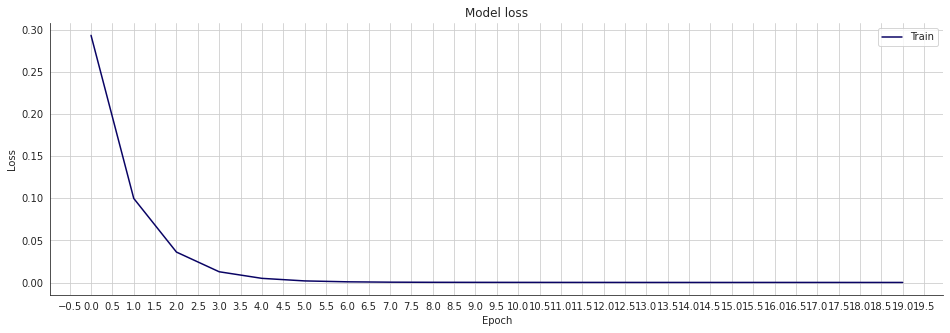

------------------------------------------------------
Median Absolute Error (MAE): 1.09
Mean Absolute Percentage Error (MAPE): 3.84 %
Median Absolute Percentage Error (MDAPE): 3.45 %


In [12]:
vrnn = V_RNN_cls(3)
vrnn.split_data(data_scaled,.2)
vrnn_model = vrnn.VRNN_model(20)
history,y_pred_scaled,y_pred,y_val_unscaled = vrnn.train(vrnn_model,20)
# Plot training & validation loss values
fig, ax = plt.subplots(figsize=(16, 5), sharex=True)
sns.lineplot(data=history.history["loss"])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(50))
plt.legend(["Train", "Val"], loc="upper right")
plt.grid()
plt.show()
print("------------------------------------------------------")
# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_val_unscaled, y_pred)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_val_unscaled, y_pred)/ y_val_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_val_unscaled, y_pred)/ y_val_unscaled)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')

## GRU 

In [13]:
class GRU_cls(Basenet):

  def __init__(self,index_Close):
    super().__init__(index_Close)
    self.x_train = None
    self.y_pred =None

  def GRU_model(self,sequence_length,optimizer = 'adam',lr=0.001):
    self.sequence_length =sequence_length
    x_train,y_train = self.partition_dataset(sequence_length,self.train_set)
    self.x_train = x_train
    if optimizer == 'adam':
      self.optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    elif optimizer == 'sgd': 
      self.optimizer = tf.keras.optimizers.SGD(learning_rate=lr, momentum=0.0)

    n_neurons = self.x_train.shape[1] * self.x_train.shape[2]
    my_GRU_model = Sequential()
    # First GRU layer with Dropout regularisation
    my_GRU_model.add(GRU(units=n_neurons, return_sequences=True, input_shape=(self.x_train.shape[1], self.x_train.shape[2]), activation='tanh'))
    my_GRU_model.add(GRU(units=n_neurons, return_sequences=True, activation='tanh'))
    my_GRU_model.add(GRU(units=n_neurons, return_sequences=True, activation='tanh'))
    my_GRU_model.add(GRU(units=n_neurons, activation='tanh'))
    my_GRU_model.add(Dense(units=1))
    
    # Compile the model
    my_GRU_model.compile(optimizer=self.optimizer, loss='mse')
    return my_GRU_model


Train :6180, Val :687, test :1717
bg_train : 6867
Training Size : 6180
Validation Size : 687
Testing Size : 1717
trainx : (6160, 20, 6)
valx : (667, 20, 6)
y_train : (6160,)
y_val : (667,)
Epoch 1/20
385/385 [==============================] - 10s 15ms/step - loss: 1.7923e-04 - val_loss: 1.2433e-05
Epoch 2/20
385/385 [==============================] - 4s 10ms/step - loss: 3.1335e-05 - val_loss: 2.2256e-05
Epoch 3/20
385/385 [==============================] - 4s 9ms/step - loss: 3.3778e-05 - val_loss: 1.3696e-05
Epoch 4/20
385/385 [==============================] - 4s 9ms/step - loss: 2.0774e-05 - val_loss: 5.0706e-05
Epoch 5/20
385/385 [==============================] - 4s 9ms/step - loss: 1.6652e-05 - val_loss: 5.8313e-06
Epoch 6/20
385/385 [==============================] - 4s 9ms/step - loss: 1.8344e-05 - val_loss: 1.0149e-05
Epoch 7/20
385/385 [==============================] - 4s 9ms/step - loss: 1.4803e-05 - val_loss: 4.3186e-06
Epoch 8/20
385/385 [==============================] 

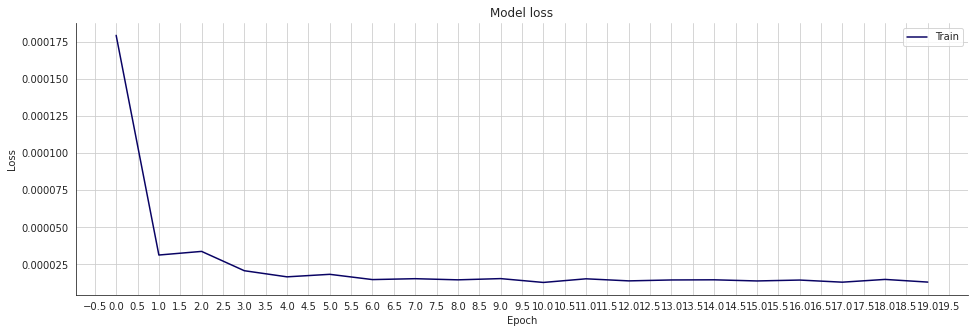

------------------------------------------------------
Median Absolute Error (MAE): 0.32
Mean Absolute Percentage Error (MAPE): 1.17 %
Median Absolute Percentage Error (MDAPE): 0.92 %


In [14]:
gru = GRU_cls(3)
gru.split_data(data_scaled,.2)
gru_model = gru.GRU_model(20)
history,y_pred_scaled,y_pred,y_val_unscaled = gru.train(gru_model,20)
# Plot training & validation loss values
fig, ax = plt.subplots(figsize=(16, 5), sharex=True)
sns.lineplot(data=history.history["loss"])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(50))
plt.legend(["Train", "Val"], loc="upper right")
plt.grid()
plt.show()
print("------------------------------------------------------")
# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_val_unscaled, y_pred)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_val_unscaled, y_pred)/ y_val_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_val_unscaled, y_pred)/ y_val_unscaled)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')